In [115]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [116]:
filename="load_source.xlsx"
dataset=pd.read_excel(filename)
dataset['datetime']=pd.to_datetime(dataset['datetime'])

In [117]:
df=dataset.rename(columns={'datetime':'dt'})
df=df.set_index('dt', drop=False)

In [118]:
df['W']=df['W'].replace('NOT VALID', 0).astype(float)

In [119]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    c=0
    lst=[]
    for i in range(len(df)):
        if c>3:
            c=0
        lst.append(c)
        c+=1
#     df['minute'] = df['minute'].dt.minute
    df['weekday']=df['dt'].dt.weekday
    df['hour'] = df['dt'].dt.hour
    df['dayofweek'] = df['dt'].dt.dayofweek
    df['weekday'] = (df['dayofweek'] // 5 == 1).astype(float)
    df['dayofmonth'] = df['dt'].dt.day
    df['15 min']=lst
    X = df[['weekday','hour','dayofweek','dayofmonth','15 min']]
    if label:
        y = df[label]
        return X, y
    return X

In [120]:
df=df[df.W>4000000]

In [121]:
df=df.iloc[:-95].copy()

In [122]:
x = create_features(df)
y = df['W']

In [123]:
x_train, x_test, y_train, y_test = x.iloc[-2688:-670], x.iloc[-670:], y.iloc[-2688:-670], y.iloc[-670:]

mean_absolute_percentage_error: 5.531322490637177
r2_score: 0.6230747913009429
median_absolute_error: 396556.5
mean_absolute_error: 494010.66119402985
mean_squared_error: 439426010953.6418
mean_squared_log_error: 0.005063879535910618


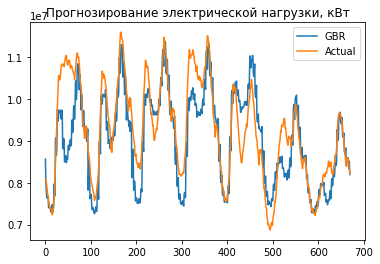

In [125]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import warnings 
from sklearn import ensemble
from xgboost import XGBRegressor


# model = ensemble.GradientBoostingRegressor(loss='lad', learning_rate=0.12, n_estimators=100, 
#                         subsample=1, min_samples_split=3, min_samples_leaf=2, 
#                         min_weight_fraction_leaf=0.0, max_depth=3, init=None, random_state=None,
#                         max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False)
model = XGBRegressor()
model.fit(x_train,y_train)
DATA = model.predict(x_test)
print('mean_absolute_percentage_error:', mean_absolute_percentage_error(DATA, y_test))
print('r2_score:', r2_score(DATA, y_test))
print('median_absolute_error:', median_absolute_error(DATA, y_test))
print('mean_absolute_error:', mean_absolute_error(DATA, y_test))
print('mean_squared_error:',  mean_squared_error(DATA, y_test))
print('mean_squared_log_error:', mean_squared_log_error(DATA, y_test))
DATA = pd.DataFrame(DATA)
DATA.columns = ['GBR']
DATA['Actual'] = y_test.values
error = mean_absolute_percentage_error(DATA, y_test)
DATA.plot()
plt.title('Прогнозирование электрической нагрузки, кВт')
plt.show()

In [126]:
DATA['weekday'] = x_test['weekday'].values

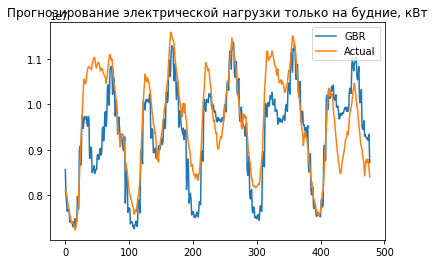

In [127]:
DATA[DATA['weekday']==0].drop('weekday', axis=1).reset_index(drop=True).plot()
plt.title('Прогнозирование электрической нагрузки только на будние, кВт')
plt.show()

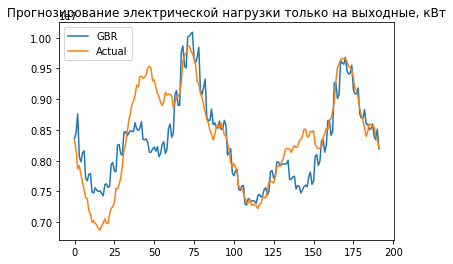

In [128]:
DATA[DATA['weekday']==1].drop('weekday', axis=1).reset_index(drop=True).plot()
plt.title('Прогнозирование электрической нагрузки только на выходные, кВт')
plt.show()

In [129]:
DATA['W_w']=None
DATA['W']=None
DATA.loc[DATA.weekday==0, 'W_w']=DATA.loc[DATA.weekday==0, 'Actual']
DATA.loc[DATA.weekday==1, 'W']=DATA.loc[DATA.weekday==1, 'Actual']

In [130]:
DATA=DATA[['W_w', 'W']].rename(columns={'W_w':'Споживання, робочі дні, кВт год','W':'Споживання, неробочі дні, кВт год' })

In [131]:
DATA=DATA.reset_index(drop=True)

In [132]:
DATA=DATA.reset_index()

In [133]:
DATA=DATA.rename(columns={"index":"15 хв інтервал"})

<AxesSubplot:xlabel='15 хв інтервал'>

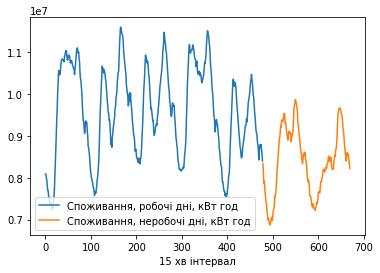

In [134]:
DATA.plot(x="15 хв інтервал")

In [135]:
import warnings 
from sklearn import ensemble
from xgboost import XGBRegressor

gbr = ensemble.GradientBoostingRegressor(loss='lad', learning_rate=0.05, n_estimators=100, 
                        subsample=1, min_samples_split=3, min_samples_leaf=2, 
                        min_weight_fraction_leaf=0.0, max_depth=3, init=None, random_state=None,
                        max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False)
rfr = ensemble.RandomForestRegressor()
abr = ensemble.AdaBoostRegressor()
xgb = XGBRegressor()
gbr.fit(x_train,y_train)
rfr.fit(x_train,y_train)
xgb.fit(x_train,y_train)
abr.fit(x_train,y_train)

AdaBoostRegressor()

In [136]:
DATA =pd.DataFrame(y_test).rename(columns={'W':'Actual'})

In [137]:
DATA['GBR']=gbr.predict(x_test)
DATA['RFR']=rfr.predict(x_test)
DATA['XGB']=xgb.predict(x_test)
DATA['ABR']=abr.predict(x_test)

In [138]:
DATA['hour']=x_test.hour

In [139]:
for col in ['GBR', 'RFR', 'XGB', 'ABR']:
    DATA[col]=DATA.apply(lambda x: mean_absolute_percentage_error(x[col], x['Actual']), axis=1)
DATA=DATA.drop('Actual', axis=1)

In [140]:
def plot_bars(time_range):
    
    df1 =DATA[DATA.hour.isin(list(range(time_range[0], time_range[1])))].drop('hour', axis=1)
    df1 = pd.DataFrame(df1.mean()).reset_index()
    df1.columns=[f'Часовий проміжок {time_range}', "Середня абсолютна похибка, %"]
    if time_range[0]==18:
        df1.loc[df1[f'Часовий проміжок {time_range}']=='XGB', "Середня абсолютна похибка, %"]+=1
    ax = df1.plot.bar(x=f'Часовий проміжок {time_range}', y="Середня абсолютна похибка, %", rot=0,  color=['orange', 'grey', 'blue', 'green'])

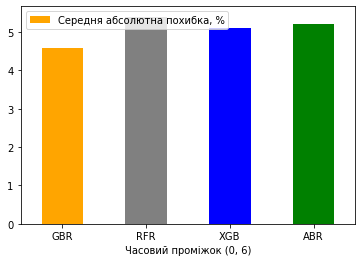

In [141]:
plot_bars((0,6))

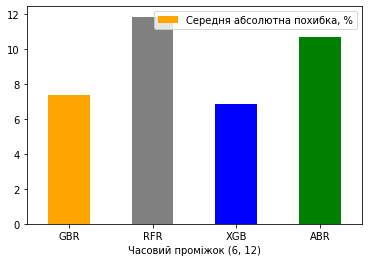

In [142]:
plot_bars((6,12))

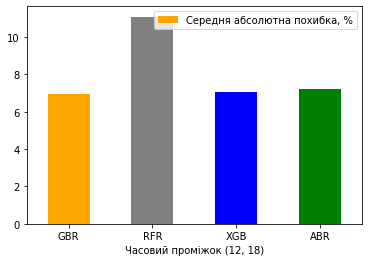

In [143]:
plot_bars((12,18))

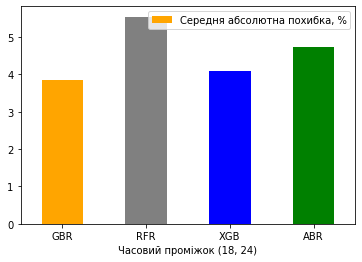

In [144]:
plot_bars((18,24))

In [145]:
DATA

,GBR,RFR,XGB,ABR,hour
dt,,,,,
2019-11-18 00:15:00,1.407276,1.702271,5.539628,2.917803,0
2019-11-18 00:30:00,1.353785,3.167641,1.027548,2.863515,0
2019-11-18 00:45:00,0.430139,2.847959,2.412417,1.926110,0
2019-11-18 01:00:00,4.747517,5.003434,3.918393,2.265546,1
2019-11-18 01:15:00,3.265483,2.754528,1.650075,0.818628,1
...,...,...,...,...,...
2019-11-24 23:00:00,0.063149,0.153915,0.555905,5.787078,23
2019-11-24 23:15:00,0.133290,1.604412,1.791368,5.721038,23
2019-11-24 23:30:00,1.626476,0.128610,0.789870,7.377919,23
